In [1]:
import pandas as pd
import requests
import json
import numpy as np
import dataretrieval as nwis
import geopandas
import geojson

# Get Regression Regions 
(https://streamstats.usgs.gov/docs/nssservices/#/RegressionRegions/GET/RegressionRegion)

In [2]:

## Regions
WA = [713,714,715,716] #https://streamstats.usgs.gov/nssservices/regressionregions?regions=WA&statisticgroups=LFS / Western and nooksack
WA = [715] #https://streamstats.usgs.gov/nssservices/regressionregions?regions=WA&statisticgroups=LFS / Western and nooksack, only 715 has geometry
OR = [481,482,483,484,485,486,487,488,489,490] #https://streamstats.usgs.gov/nssservices/regressionregions?regions=OR&statisticgroups=LFS
ID = [126,127,128,129,130,131,132,133] # https://streamstats.usgs.gov/nssservices/regressionregions?regions=OR&statisticgroups=LFS / All come from same pub

PNW_regions = WA + OR + ID

StreamStatsServiceURLS = {
    'gage': 'https://streamstats.usgs.gov/nssservices/regressionregions/'
    }


gageURLParams = {
    'includeGeometry':'TRUE'
    }

for i in range(0,len(PNW_regions)):
    gageResponse = requests.get(url = StreamStatsServiceURLS['gage'] + str(PNW_regions[i]), params = gageURLParams)

    if gageResponse.status_code == 200:
        cookies = gageResponse.cookies
        try:
            gageStats = json.loads(gageResponse.content.decode('utf-8'))
            data = gageStats["location"]
            with open('../data/mapping/SS_LFS_Regions/'+ str(PNW_regions[i]) +'_region.json', 'w') as f:
                json.dump(data, f)
        except:
            pass

    else:
        pass

In [3]:
out = pd.DataFrame()
for i in PNW_regions:
    df = geopandas.read_file("../data/mapping/SS_LFS_Regions/"+str(i)+"_region.json",driver='GeoJSON')
    df["region"] = i
    out = pd.concat([out,df])
    
out = out.reset_index(drop=True)

In [4]:
## Deliniate by state
out.loc[out.region.isin(ID),"state"]="ID"
out.loc[out.region.isin(WA),"state"]="WA"
out.loc[out.region.isin(OR),"state"]="OR"

## Set regression regions
#OR
PNW_RR = {481:'OR1',
 483:'OR2',
 484:'OR3',
 485:'OR4',
 486:'OR5',
 487:'OR6',
 488:'OR7',
 489:'OR8',
 490:'OR9',
 482:'OR10',
 126:'ID1',
 127:'ID2',
 128:'ID3',
 129:'ID4',
 130:'ID5',
 131:'ID6',
 132:'ID7',
 133:'ID8',
 715:'WA1',
}

out['RegRegion'] = out['region'].map(PNW_RR)

In [5]:
states = geopandas.read_file("../data/mapping/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs(epsg=4269)
st = ["Idaho",'Washington','Oregon']
states = states[states["NAME"].isin(st)]

In [6]:
out = out.to_crs(epsg=4269)

OR = out[out.state == "OR"]
ID = out[out.state == "ID"]
other = out[out.state != "OR"]

In [12]:
OR_geo = states[states.NAME == "Oregon"]
other_geo = states[states.NAME != "Oregon"]

OR_out = OR.overlay(OR_geo, how='difference')
OR_out = geopandas.clip(OR_out,other_geo)

OR_in = geopandas.clip(OR,OR_geo)

In [8]:
ID_geo = states[states.NAME == "Idaho"]

ID_out = ID.overlay(ID_geo, how='difference')
ID_out = geopandas.clip(ID_out,OR_geo)

In [17]:
ovrlap = geopandas.clip(other,other_geo)
ovrlap = ovrlap.overlay(OR_out,how='difference')

## Oregon WetDry extent

In [53]:
wetDryMod = ["OR1","OR9","OR10","OR3"]
OR_WD = OR_in[OR_in.RegRegion.isin(wetDryMod)]

## Plot

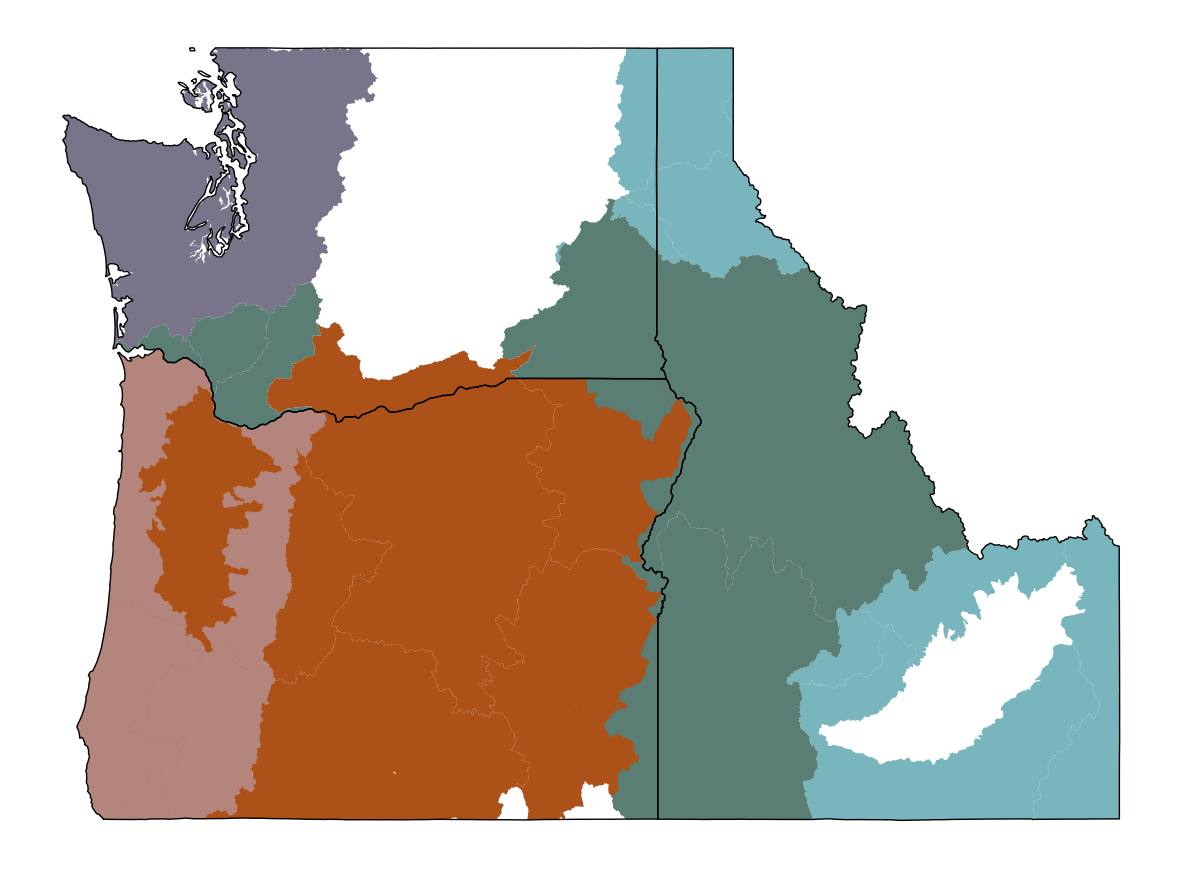

In [69]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15, 15))

pal = {'OR': '#A33F00',
       'WA': '#7A748A',
       'ID': '#79B5BD'}


ovrlap.plot(ax=ax,
            color = ovrlap['state'].map(pal))
OR_in.plot(ax=ax,
           color = '#A33F00',
           edgecolor = None,
           alpha = 0.9
          )
OR_out[OR_out.RegRegion == "OR5"].plot(ax=ax,
                                       color="#A33F00",
                                       edgecolor = None,alpha = 0.9
                                      )

OR_out[OR_out.RegRegion != "OR5"].plot(ax=ax,
            color = "#5A7E74",
            edgecolor = None)

ID_out.plot(ax=ax,
            color = "#5A7E74",
            edgecolor = None)

OR_WD.plot(ax=ax,
          edgecolor= None,
          color = "#B3857C",zorder=9)

states.plot(ax=ax,facecolor="none",edgecolor = "black",zorder=10)

ax.set_axis_off();
plt.savefig("../docs/PNW_StreamStats_RegRegions.png",dpi=600,transparent=True)

In [ ]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15, 15))

pal = {'OR': '#A33F00',
       'WA': '#7A748A',
       'ID': '#79B5BD'}


toPlot = out[out.RegRegion != "OR1"]
states.plot(ax=ax,facecolor="none",edgecolor = "black")
out.plot(ax=ax,color = out['state'].map(pal),alpha = 0.7,edgecolor = "black",legend=True)

ax.set_axis_off();
# plt.savefig("../docs/PNW_StreamStats_RegRegions.pdf")